# Notes for the script $\textit{mapping_points.py}$

### Introduction 

The purpose of the script is to check the turbine efficiency variation when the temperatures and the pressures are mapped from a correlated space ($\textit{physical space}$) to a new uncorrelated standard space.
The inverse Nataf transformation has been used as a mapping tool.

## Section 1: Definition of Marginals

The definition of four marginals, here four truncated gaussians defined with the mean values of temperatures and pressures, is necessary for defining a $\textit{Nataf}$ object: we want to map points from a physical space, in which quantities are correlated, to a new standard space in which all the features of the system under study lose their correlation.



In [ ]:
import numpy as np
from equadratures import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

""" Mean values for temperatures and variances;
    gamma: adiabatic isentropic exponent for gas
"""
T01 = 800.
T02 = 700.
P01 = 10*10**5
P02 = 5*10**5
gamma = 1.4

""" construction of the correlated points: 
    temperatures and pressures
"""

t1 = Parameter(distribution='truncated-gaussian', order=5, shape_parameter_A = T01, shape_parameter_B = 1., upper = T01*1.1, lower = T01*.9)
t2 = Parameter(distribution='truncated-gaussian', order=5, shape_parameter_A = T02, shape_parameter_B = 1., upper = T02*1.1, lower = T02*.9)
p1 = Parameter(distribution='truncated-gaussian', order=5, shape_parameter_A = P01, shape_parameter_B = 1., upper = P01*1.1, lower = P01*.9)
p2 = Parameter(distribution='truncated-gaussian', order=5, shape_parameter_A = P02, shape_parameter_B = 1., upper = P02*1.1, lower = P02*.9)

Two different set of points will be mapped: the first one consists of quadrature points obtained with a Quadrature rule while the second is represented by N points sampled using a Monte Carlo method.
The correlation matrix defines a low correlation between temperatures (0.3) and a medium correlation between pressures (0.6). These values has been kept as constant during the calculations. 

An instance to the Nataf class allows to use the methods $\textit{getCorrelatedSamples}$ for MonteCarlo set of points ad $\textit{U2C}$ for the quadrature points: in this way the correlation defined by $R$ is imposed.

In [3]:
""" quadrature rule
"""
myBasis = Basis('Tensor grid')
normal = Parameter(order=5, distribution='gaussian', shape_parameter_A = 0., shape_parameter_B = 1.)
standardPoly = Polyint([normal, normal, normal, normal], myBasis)
quad = standardPoly.quadraturePoints

# definition of the correlation matrix
R = np.matrix([[1., .3, 0., 0.],
               [.3, 1., 0., 0.],
               [0., 0., 1., .6],
               [0., 0., .6, 1.]])

# definition of a nataf object
nataf_obj = Nataf([t1, t2, p1, p2], R) 

# correlated samples
corr_pnts = nataf_obj.getCorrelatedSamples(N=3000)
quad_pnts = nataf_obj.U2C(quad)

The Cholesky decomposition of fictive matrix R0 is:
[[1.        0.        0.        0.       ]
 [0.3       0.9539392 0.        0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.6       0.8      ]]
The fictive matrix is:
[[1.  0.3 0.  0. ]
 [0.3 1.  0.  0. ]
 [0.  0.  1.  0.6]
 [0.  0.  0.6 1. ]]


A function for the calculation of the turbine efficiency has been written: the input parameters are represented by the couples of temperatures and pressures, as reported in the lines below.

In [4]:
def efficiency(t1, t2, p1, p2, gamma):
    eta = (t1 -t2)/(t1* (1- (p2/p1)**((gamma-1.)/gamma)))
    return eta

## Section 2: set of correlated points

In this part of the script the turbine efficiency has been calculated by using the correlated points sets (both for Monte Carlo and quadrature points).
To this aim two different $\textit{for}$ statement has been run.

At the end of this part, a graphical representation of the results has been reported: the grey-scale color in each point is representative of the efficiency in a determined working point (so for a given couple of temperatures and pressures). The values of abscissas and ordinates are respectively the first and the second temperature $T_1$, $T_2$: they have been choosen because the efficiency variation is more sensitive to temperatures than a pressure value change.

In [5]:
efficiency_corr = np.zeros((len(corr_pnts),1))
efficiency_quad = np.zeros((len(quad_pnts),1))
x = np.zeros((len(efficiency_corr), 1))
y = np.zeros((len(efficiency_corr), 1))
xq = np.zeros((len(efficiency_quad), 1)) 
yq = np.zeros((len(efficiency_quad), 1)) 
for i in range(len(x)):
    x[i] = corr_pnts[i,0]
    y[i] = corr_pnts[i,1]
    efficiency_corr[i] = efficiency(corr_pnts[i,0], corr_pnts[i,1], corr_pnts[i,2], corr_pnts[i,3], gamma)

for i in range(len(quad_pnts)):
    xq[i] = quad_pnts[i,0]
    yq[i] = quad_pnts[i,1]
    efficiency_quad[i] = efficiency(quad_pnts[i,0], quad_pnts[i,1], quad_pnts[i,2], quad_pnts[i,3], gamma)

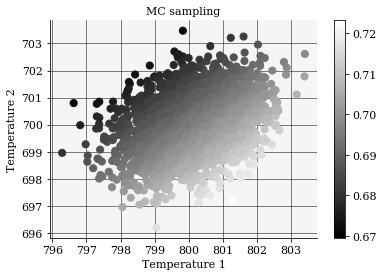

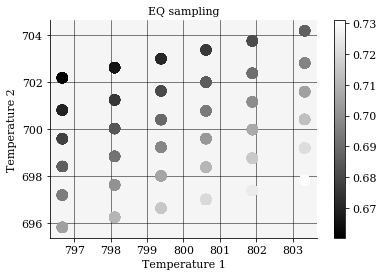

In [6]:
""" PCOLOR FOR CONTOUR PLOT OF EFFICIENCY :
"""
plt.figure()
plt.grid(linewidth=0.5, color='k')
plt.scatter(x,y, c=efficiency_corr, s=50)
plt.gray()
plt.colorbar()
plt.xlabel('Temperature 1')
plt.ylabel('Temperature 2')
plt.title('MC sampling')
plt.show()

plt.figure()
plt.grid(linewidth=0.5, color='k')
plt.scatter(xq,yq, c=efficiency_quad, s=100)
plt.gray()
plt.colorbar()
plt.xlabel('Temperature 1')
plt.ylabel('Temperature 2')
plt.title('EQ sampling')
plt.show()

## Section 3: Mapping into the uncorrelated space

The points used in the previous section have been mapped into a new standard space by applying the Nataf transformation: the method $\textit{C2U}$ has been used to this aim.

In [7]:
"""     PART 2: MAP INTO A STANDARD SPACE
"""

uncorr_pnts = nataf_obj.C2U(corr_pnts)
uncorr_quad = nataf_obj.C2U(quad_pnts)

The two new sets of uncorrelated points has been finally used to calculate the value of the turbine efficiency; in the following plot the results have been reported: each point is representative of a given working-condition and the grey-scale colour indicates the efficiency variation.
In the plots only temperatures has been plotted, because the variation of efficiency is more appreciable.

Since the points become uncorrelated in a standard space, they have a mean value of zero and a unit variance: for this reason it is necessary to shift all points in the graphs with the mean values of temperatures, in this way a feasible value of efficiency is reached.

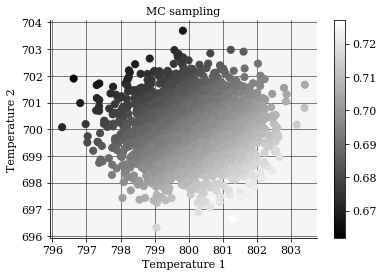

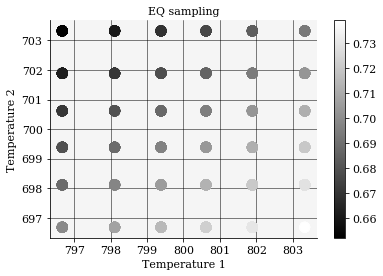

In [10]:
#_______________________________________________________________________________
# if the reader wants to check the Nataf direct transformation of points can
# uncomment the following lines: the plot of standard transformed points, both
# for Monte Carlo and Quadrature Points, will be reported.
#_______________________________________________________________________________

#plt.figure()
#plt.grid(linewidth=0.5, color='k')
#plt.plot(uncorr_pnts[:,0], uncorr_pnts[:,1], 'bo')
#plt.title('std space for MQ')
#plt.xlabel('Temperature 1')
#plt.ylabel('Temperature 2')
#plt.show()

#plt.figure()
#plt.grid(linewidth=0.5, color='k')
#plt.plot(uncorr_quad[:,0], uncorr_quad[:,1], 'bo')
#plt.title('std space for EQ')
#plt.xlabel('Temperature 1')
#plt.ylabel('Temperature 2')
#plt.show()
#_____________________________________________________________________________#

x = np.zeros((len(uncorr_pnts),1))
y = np.zeros((len(x),1))
z = np.zeros((len(x),1))

""" in the following lines the mean values of temperatures and
    pressures have been added to std pnts because a correct
    value of efficiency can be obtained.
"""
for i in range(len(x)):
    x[i] = uncorr_pnts[i,0] + T01
    y[i] = uncorr_pnts[i,1] + T02
    p1 = uncorr_pnts[i,2] + P01
    p2 = uncorr_pnts[i,3] + P02
    z[i] = efficiency(x[i], y[i], p1, p2, gamma)

xq = np.zeros((len(uncorr_quad),1))
yq = np.zeros((len(xq),1))
zq = np.zeros((len(xq),1))

for i in range(len(xq)):
    xq[i] = uncorr_quad[i,0] + T01
    yq[i] = uncorr_quad[i,1] + T02
    p1 = uncorr_quad[i,2] + P01
    p2 = uncorr_quad[i,3] + P02
    zq[i] = efficiency(xq[i], yq[i], p1, p2, gamma)

""" PCOLOR FOR CONTOUR PLOT OF EFFICIENCY :
"""
plt.figure()
plt.grid(linewidth=0.5, color='k')
plt.scatter(x,y, c=z, s=50 )
plt.gray()
plt.colorbar()
plt.title('MC sampling')
plt.xlabel('Temperature 1')
plt.ylabel('Temperature 2')
plt.show()

plt.figure()
plt.grid(linewidth=0.5, color='k')
plt.scatter(xq,yq, c=zq, s=100)
plt.gray()
plt.colorbar()
plt.title('EQ sampling')
plt.xlabel('Temperature 1')
plt.ylabel('Temperature 2')
plt.show()
